# 7. Analyzing Text

_Damian Trilling and Penny Sheets_

This notebook is meant to show you some more ways of analyzing data that go
beyond methods like `df.describe()` or `Counter()` etc., which we used last week
already. In particular, we are going to look into analyzing textual data.

We will both look at _bottom up_ and _top down_ approaches.


## Download the data

We will use a dataset by Schumacher et al. (2016). From the abstract:

> This paper presents EUSpeech, a new dataset of 18,403 speeches from EU leaders
> (i.e., heads of government in 10 member states, EU commissioners, party
> leaders in the European Parliament, and ECB and IMF leaders) from 2007
> to 2015. These speeches vary in sentiment, topics and ideology, allowing for
> fine-grained, over-time comparison of representation in the EU. The member
> states we included are Czech Republic, France, Germany, Greece, Netherlands,
> Italy, Spain, United Kingdom, Poland and Portugal.

Schumacher, G, Schoonvelde, M., Dahiya, T., Traber, D, & de Vries, E. (2016):
_EUSpeech: a New Dataset of EU Elite Speeches_.
[doi:10.7910/DVN/XPCVEI](http://dx.doi.org/10.7910/DVN/XPCVEI)

Download and unpack the following file:

```
speeches_csv.tar.gz
```

In the .tar.gz file, you find a .zip file.

See below a screenshot of how this looks like in Lubuntu (double-click on
"speeches_csv.zip" in the left window, then the right window will open. Click on
"Extract"). On some systems, you need to actually to three steps of
uncompressing: double-click on the tar.gz file to make it a .gz file, and
double-click on that one to get the zip file, and then the same thing again for
the zip file.

**On Windows, you may need to install a unzip program like
[7zip](https://www.7-zip.org/) first **

**Within that archive, you find a file `Speeches_UK_Cleaned.csv`. That's the one
we need -- save it inthe directory in which you save your Jupyter Notebooks!**


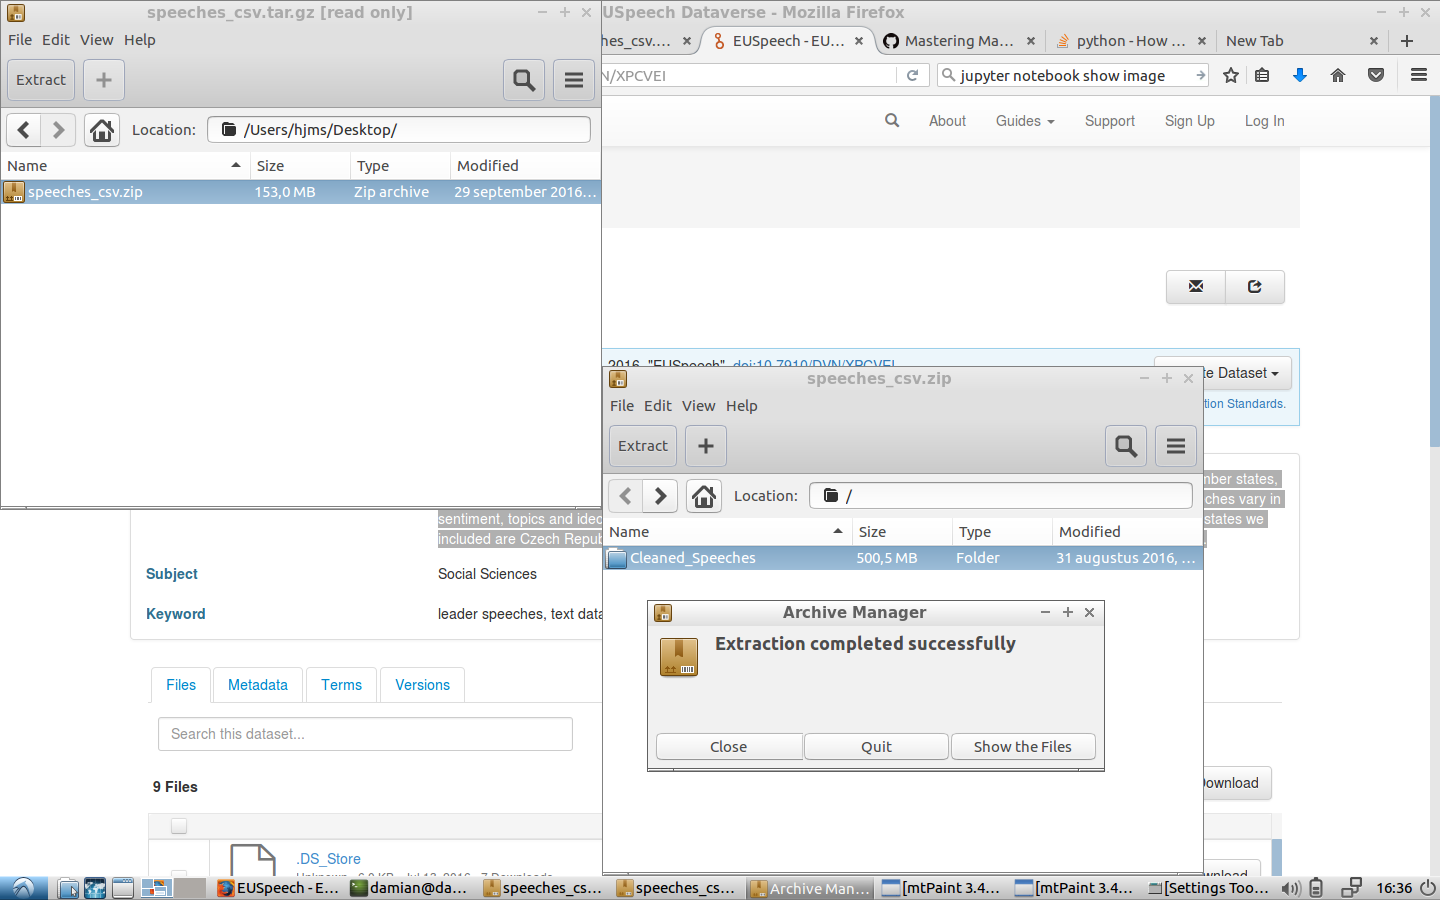

In [1]:
from IPython.display import Image
Image("https://github.com/damian0604/bdaca/raw/master/ipynb/euspeech_download.png")

## Getting started

It is a good custom to import all modules that you need at the beginning of your
notebook. I'll explain in the leson what these models do


In [2]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
%matplotlib inline

In [3]:
# if you need to install wordcloud, you can do it as follows:
# !pip install wordcloud

In [4]:
import wordcloud

## Data preparation

First of all, we will read the dataset in a Pandas Dataframe. In this case, it
seems that there are no column headers (try to run it without the
header-argument to see what happens!)


In [5]:
df = pd.read_csv('Speeches_UK_Cleaned.csv', header=None)   # the first line contains already data and not column headers

In [6]:
df[33:37]

,0,1,2,3,4,5,6,7
33,PM speech on opportunity,22-06-2015,Great Britain,D. Cameron,3352,<p>I </p><p>said on the steps of Downing Stree...,said step down street may would one nation gov...,en
34,PM press conference with Enda Kenny: June 2015,18-06-2015,Great Britain,D. Cameron,2112,"<p>Good afternoon and welcome, and it’s great ...",good afternoon welcom great welcom good friend...,en
35,Magna Carta 800th anniversary: PM's speech,15-06-2015,Great Britain,D. Cameron,659,"<p>800 years ago, on this day, King John put h...",year ago day king put seal document would chan...,en
36,G7: Statement by David Cameron and Barack Obama,08-06-2015,Great Britain,D. Cameron,623,<p>It is wonderful to be back with my good fri...,wonder back good friend partner cameron d like...,en


In [7]:
df.shape

(787, 8)

In [8]:
df.head()

,0,1,2,3,4,5,6,7
0,EU Council: PM press conference,18-12-2015,Great Britain,D. Cameron,2877,<p>This European Council has focused on 3 issu...,european council focus issu uk renegoti migrat...,en
1,PM statement in Poland: 10 December 2015,10-12-2015,Great Britain,D. Cameron,866,<p>Thank you Prime Minister for welcoming me h...,thank prime minist welcom warsaw honour first ...,en
2,"PM statement on talks in Romania, 9 December 2015",09-12-2015,Great Britain,D. Cameron,726,<p>Thank you President Iohannis for welcoming ...,thank presid iohanni welcom bucharest today pl...,en
3,PM Speech: This is a government that delivers,07-12-2015,Great Britain,D. Cameron,6211,<p>This is a government that delivers</p><p>Th...,govern deliversthank much brief introduct grea...,en
4,PM Bulgaria visit 3 December 2015: press confe...,07-12-2015,Great Britain,D. Cameron,773,"<p>Well thank you very much Prime Minister, th...",well thank much prime minist thank boyko good ...,en


We now probably got some sense what the columns mean, so let's give them
headers!


In [9]:
df.columns = ['what','when','country','who','number', 'text', 'text_clean','language']

In [10]:
df.head()

,what,when,country,who,number,text,text_clean,language
0,EU Council: PM press conference,18-12-2015,Great Britain,D. Cameron,2877,<p>This European Council has focused on 3 issu...,european council focus issu uk renegoti migrat...,en
1,PM statement in Poland: 10 December 2015,10-12-2015,Great Britain,D. Cameron,866,<p>Thank you Prime Minister for welcoming me h...,thank prime minist welcom warsaw honour first ...,en
2,"PM statement on talks in Romania, 9 December 2015",09-12-2015,Great Britain,D. Cameron,726,<p>Thank you President Iohannis for welcoming ...,thank presid iohanni welcom bucharest today pl...,en
3,PM Speech: This is a government that delivers,07-12-2015,Great Britain,D. Cameron,6211,<p>This is a government that delivers</p><p>Th...,govern deliversthank much brief introduct grea...,en
4,PM Bulgaria visit 3 December 2015: press confe...,07-12-2015,Great Britain,D. Cameron,773,"<p>Well thank you very much Prime Minister, th...",well thank much prime minist thank boyko good ...,en


## Bottom-up analysis

There are several approaches to data analysis: bottom up and top down. With the
former, you try to recognize patterns and describe the data; with the latter,
you aim at identifying concepts you have defined in advance. Let's start
bottom-up.t

I give some examples in the following lines, _but try out your own stuff!!_


In [11]:
df['who'].value_counts()

who
D. Cameron    493
G. Brown      283
T. Blair       11
Name: count, dtype: int64

Remember that in Python, everything is an object. Therefore, we can _chain_
methods and apply the `.plot()` method to the output object of `.value_counts()`
if we want to:


<Axes: xlabel='who'>

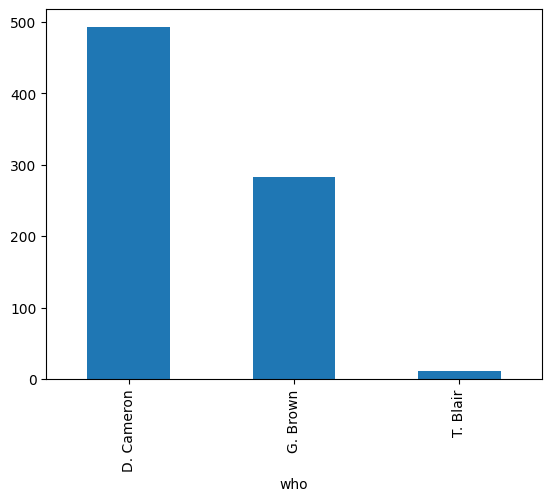

In [12]:
df['who'].value_counts().plot(kind='bar')

### Simple bottom-up approaches to text analysis

Let's get most common words. The command below basically takes all cleaned
texts, joins them together with a space between them, and then splits this long
string into words.


In [13]:
c = Counter(" ".join(df.text_clean).split())

In [14]:
c.most_common(20)

[('peopl', 11314),
 ('think', 9209),
 ('countri', 9020),
 ('make', 6918),
 ('go', 6428),
 ('world', 6218),
 ('want', 6121),
 ('work', 6006),
 ('need', 5798),
 ('year', 5649),
 ('minist', 5467),
 ('ve', 5431),
 ('get', 5002),
 ('prime', 4976),
 ('govern', 4940),
 ('britain', 4842),
 ('one', 4713),
 ('say', 4580),
 ('also', 4541),
 ('new', 4320)]

Let's generate a word cloud instead!

More examples at https://github.com/amueller/word_cloud


(-0.5, 799.5, 399.5, -0.5)

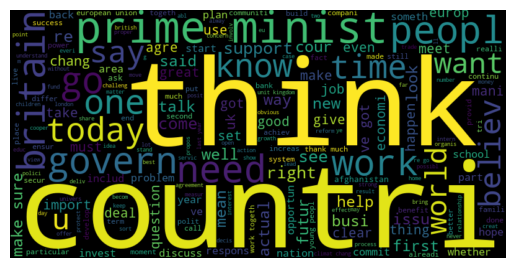

In [15]:
mywordcloud = WordCloud(width=800, height=400).generate(" ".join(df.text_clean))
plt.imshow(mywordcloud, interpolation='bilinear')
plt.axis("off")

In [16]:
mywordcloud.to_file('mywordcloud.png')

In [17]:
mywordcloud?

Type:        WordCloud
String form: <wordcloud.wordcloud.WordCloud object at 0x332e7df40>
File:        /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wordcloud/wordcloud.py
Docstring:  
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (default=200)
    Height of the canvas.

prefer_horizontal : float (default=0.90)
    The ratio of times to try horizontal fitting as opposed to vertical.
    If prefer_horizontal < 1, the algorithm will try rotating the word
    if it doesn't fit. (There is currently no built-in way to get only
    vertical words.)

mask : nd-array or None (default=None)
    If not None, gives a binary mask on where to draw words. If mask is 

Let's now see what happens if we only take some of the speeches:


In [18]:
allspeechesbycameron = " ".join(df[df['who']=='D. Cameron']['text_clean'])

In [19]:
allspeechesbycameron[:100]

'european council focus issu uk renegoti migrat terror talk renegoti last night come back short first'

In [20]:
len(allspeechesbycameron.split())

562234

(-0.5, 799.5, 399.5, -0.5)

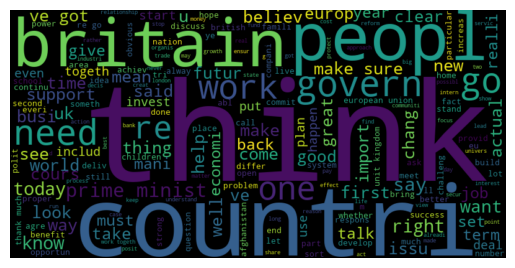

In [21]:
wordcloud = WordCloud(width=800, height=400).generate(allspeechesbycameron)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Let's turn it around and look for specific things (top-down)

Imagine we are interested in references to `terror`. Feel free to choose any
other term!

We can actually use regular expressions (google for it!), so we can use
`[tT]error` to allow for both upper and lower case. Or we can say
`[tT]erroris[mt]`.

Let's first look at it and then make a new column with it


In [22]:
df['text'].str.count('[tT]error')

0      7
1      0
2      0
3      0
4      2
      ..
782    0
783    0
784    0
785    0
786    0
Name: text, Length: 787, dtype: int64

In [23]:
df['terrorrefs'] = df['text'].str.count('[tT]error')

In [24]:
df['terrorrefs'].describe()

count    787.000000
mean       1.731893
std        4.435921
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       44.000000
Name: terrorrefs, dtype: float64

In [25]:
df['terrorrefs'].idxmax() 

687

In [26]:
df.iloc[687]

what            Permanent Link to Press conference in Islamabad
when                                                 14-12-2008
country                                           Great Britain
who                                                    G. Brown
number                                                     2954
text          <p>Transcript of a press conference given by t...
text_clean    transcript press confer given prime minist mr ...
language                                                     en
terrorrefs                                                   44
Name: 687, dtype: object

### Making comparisons

Of course, it would be cool to get some idea whether this differs between some
groups of speeches. For this, we can use subsetting (see last week) and repeat
the analysis three times, or we can use `.groupby`:


In [27]:
df.groupby('who')['terrorrefs'].describe()

,count,mean,std,min,25%,50%,75%,max
who,,,,,,,,
D. Cameron,493.0,1.511156,3.382520,0.0,0.0,0.0,1.0,25.0
G. Brown,283.0,2.109541,5.842375,0.0,0.0,0.0,1.0,44.0
T. Blair,11.0,1.909091,3.832872,0.0,0.0,0.0,1.0,11.0


In [28]:
df.groupby('who')['terrorrefs'].sum()

who
D. Cameron    745
G. Brown      597
T. Blair       21
Name: terrorrefs, dtype: int64

Instead of counting the number of all references to terror, let's count the
number of speeches that have at leas tone reference:


In [29]:
df['terrorrefsdummy'] = df['terrorrefs']>0
df['terrorrefsdummy'] = df['terrorrefsdummy'].map(int)
df

,what,when,country,who,number,text,text_clean,language,terrorrefs,terrorrefsdummy
0,EU Council: PM press conference,18-12-2015,Great Britain,D. Cameron,2877,<p>This European Council has focused on 3 issu...,european council focus issu uk renegoti migrat...,en,7,1
1,PM statement in Poland: 10 December 2015,10-12-2015,Great Britain,D. Cameron,866,<p>Thank you Prime Minister for welcoming me h...,thank prime minist welcom warsaw honour first ...,en,0,0
2,"PM statement on talks in Romania, 9 December 2015",09-12-2015,Great Britain,D. Cameron,726,<p>Thank you President Iohannis for welcoming ...,thank presid iohanni welcom bucharest today pl...,en,0,0
3,PM Speech: This is a government that delivers,07-12-2015,Great Britain,D. Cameron,6211,<p>This is a government that delivers</p><p>Th...,govern deliversthank much brief introduct grea...,en,0,0
4,PM Bulgaria visit 3 December 2015: press confe...,07-12-2015,Great Britain,D. Cameron,773,"<p>Well thank you very much Prime Minister, th...",well thank much prime minist thank boyko good ...,en,2,1
...,...,...,...,...,...,...,...,...,...,...
782,Permanent Link to My UK Competition - Transcript,03-04-2007,Great Britain,T. Blair,369,"<p>The My UK competition, which was run by Blu...",uk competit run blue peter down street invit v...,en,0,0
783,Permanent Link to Blue Peter - Transcript,03-04-2007,Great Britain,T. Blair,1358,<p>As part of a special BBC-Downing Street com...,part special bbcdown street competit blue pete...,en,0,0
784,Permanent Link to Catherine Tate - Transcript,03-04-2007,Great Britain,T. Blair,669,<p>Tony Blair has to deal with stroppy teenage...,toni blair deal stroppi teenag lauren better k...,en,0,0
785,Permanent Link to Our Nation’s Future - the Ro...,30-03-2007,Great Britain,T. Blair,3964,<p>30 March 2007</p><p>The PM focused on the c...,march pm focus chang natur work way economi ev...,en,0,0


In [30]:
df.groupby('who')['terrorrefsdummy'].sum()

who
D. Cameron    161
G. Brown       86
T. Blair        4
Name: terrorrefsdummy, dtype: int64

In the following lines, you find a quick preview of what we will do a bit more
on Wednesday: joining tables. Remember that the output generated above can be
seen as just another object, which we can turn into a dataframe:


In [31]:
terrorspeeches = df.groupby('who')['terrorrefsdummy'].sum()
totalspeeches = df['who'].value_counts()

In [32]:
df1 = pd.DataFrame(terrorspeeches)
df1

,terrorrefsdummy
who,
D. Cameron,161
G. Brown,86
T. Blair,4


In [33]:
df2= pd.DataFrame(totalspeeches)
df2

,count
who,
D. Cameron,493
G. Brown,283
T. Blair,11


In [34]:
df1.join(df2)

,terrorrefsdummy,count
who,,
D. Cameron,161,493
G. Brown,86,283
T. Blair,4,11


In [35]:
df3 = df1.join(df2)
df3.columns = ['speeches about terror','total speeches']

In [36]:
df3

,speeches about terror,total speeches
who,,
D. Cameron,161,493
G. Brown,86,283
T. Blair,4,11


In [37]:
df3['ratio'] = df3['speeches about terror']/df3['total speeches']

In [38]:
df3

,speeches about terror,total speeches,ratio
who,,,
D. Cameron,161,493,0.326572
G. Brown,86,283,0.303887
T. Blair,4,11,0.363636


<Axes: xlabel='who'>

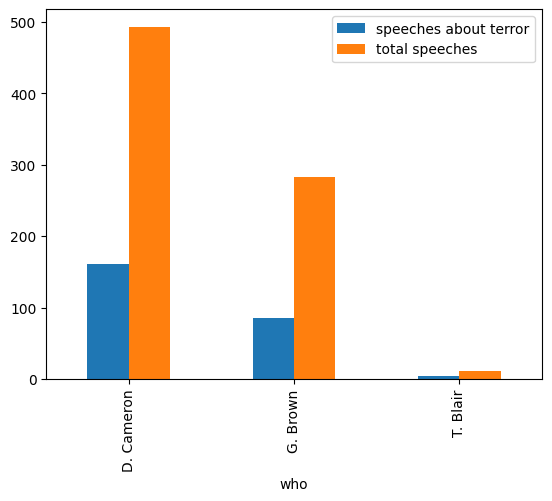

In [39]:
df3[['speeches about terror', 'total speeches']].plot(kind='bar')

<Axes: xlabel='who'>

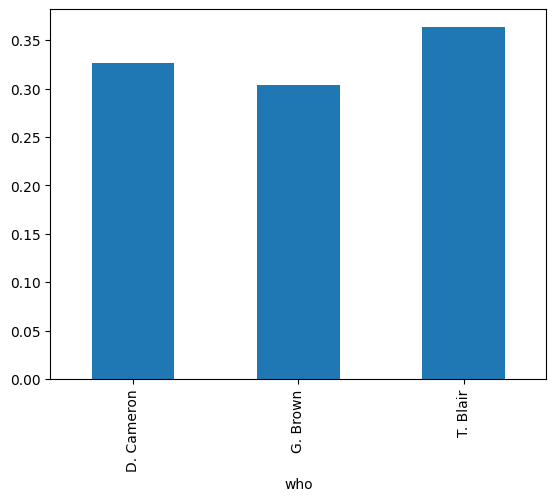

In [40]:
df3['ratio'].plot(kind='bar')

## Going in-depth

We created new columns above to indicate whether a speech was about terrorism or
not. We can now reuse this to actually read such a speech.


In [41]:
df[df['terrorrefsdummy'] == True]['what'].value_counts()

what
Transcript: Speech at the University of Nottingham, Malaysia            3
Permanent Link to Press conference with President Zardari               2
Permanent Link to Question and answer session at New York University    2
Permanent Link to Statement on European Council meeting                 2
Permanent Link to Speech and Q and A in Scotland                        2
                                                                       ..
PM's closing remarks at NATO Summit Chicago                             1
David Cameron with the Prime Minister of Malaysia                       1
Prime Minister in Malaysia                                              1
Transcript: PM speech in Indonesia                                      1
Permanent Link to April monthly press conference                        1
Name: count, Length: 245, dtype: int64

In [42]:
df[df['what'] == "PM's speech to the Jamaican Parliament"]

,what,when,country,who,number,text,text_clean,language,terrorrefs,terrorrefsdummy
17,PM's speech to the Jamaican Parliament,30-09-2015,Great Britain,D. Cameron,2456,"<p>Mr Speaker, Mr President. Honourable Member...",mr speaker mr presid honour member hous let fi...,en,1,1


In [43]:
df[df['what'] == "PM's speech to the Jamaican Parliament"]['text'].str.cat()

'<p>Mr Speaker, Mr President. Honourable Members of both Houses.</p><p>Let me first thank the Most Honourable Prime Minister and the Most Honourable Leader of the Opposition for their kind words of welcome. To be invited here to address this joint sitting of Parliament is a great honour. It’s also a genuine pleasure.</p><p>This place feels instantly familiar. These benches, the mace in front of us, the atmosphere - there is much about this place that reminds me of home. Although so far, it looks far better behaved. But this familiarity is about much more than just bricks and mortar – it is a warm reminder of the strong democratic and parliamentary links that bind us together.</p><p>And the strong links that bind the UK, not just to Jamaica, but to the whole Commonwealth Caribbean.</p><p>I’ve come to the Caribbean – and to Jamaica in particular – to celebrate these extraordinary ties.</p><p>When the world faced despotism and evil in two World Wars, British and Jamaican soldiers, and sol

In [44]:
df['words'] = df['text'].map(lambda x: len(x.split()))

<Axes: xlabel='words'>

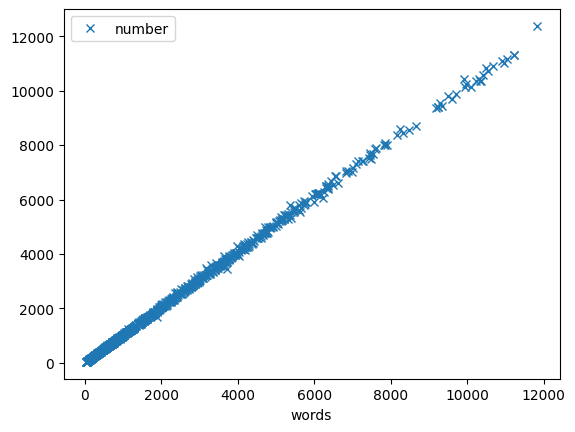

In [45]:
df.plot(x='words', y='number', style='x')

# (Non-graded) homework

Download the whole EU Speech dataset (see beginning of the notebook) and analyze
one of the sub-datasets that you are interested in.

Think about both bottom-up and top-down approaches!
